# Homework03:  Topic Modeling with Latent Semantic Analysis

In [1]:
from collections import Counter
import pandas as pd
import numpy as np
import math
import scipy.stats as stats

Latent Semantic Analysis (LSA) is a method for finding latent similarities between documents treated as a bag of words by using a low rank approximation. It is used for document classification, clustering and retrieval. For example, LSA can be used to search for prior art given a new patent application. In this homework, we will implement a small library for simple latent semantic analysis as a practical example of the application of SVD. The ideas are very similar to PCA. SVD is also used in recommender systems in an similar fashion (for an SVD-based recommender system library, see [Surpise](http://surpriselib.com). 

We will implement a toy example of LSA to get familiar with the ideas. If you want to use LSA or similar methods for statistical language analysis, the most efficient Python libraries are probably [gensim](https://radimrehurek.com/gensim/) and [spaCy](https://spacy.io) - these also provide an online algorithm - i.e. the training information can be continuously updated. Other useful functions for processing natural language can be found in the [Natural Language Toolkit](http://www.nltk.org/).

**Note**: The SVD from scipy.linalg performs a full decomposition, which is inefficient since we only need to decompose until we get the first k singluar values. If the SVD from `scipy.linalg` is too slow, please use the `sparsesvd` function from the [sparsesvd](https://pypi.python.org/pypi/sparsesvd/) package to perform SVD instead.  You can install in the usual way with 
```
!pip install sparsesvd
```

Then import the following
```python
from sparsesvd import sparsesvd 
from scipy.sparse import csc_matrix 
```

and use as follows
```python
sparsesvd(csc_matrix(M), k=10)
```

**Exercise 1 (20 points)**.  Calculating pairwise distance matrices.

Suppose we want to construct a distance matrix between the rows of a matrix. For example, given the matrix 

```python
M = np.array([[1,2,3],[4,5,6]])
```

the distance matrix using Euclidean distance as the measure would be
```python
[[ 0.000  1.414  2.828]
 [ 1.414  0.000  1.414]
 [ 2.828  1.414  0.000]] 
```
if $M$ was a collection of column vectors.

Write a function to calculate the pairwise-distance matrix given the matrix $M$ and some arbitrary distance function. Your functions should have the following signature:
```
def func_name(M, distance_func):
    pass
```

0. Write a distance function for the Euclidean, squared Euclidean and cosine measures.
1. Write the function using looping for M as a collection of row vectors.
2. Write the function using looping for M as a collection of column vectors.
3. Wrtie the function using broadcasting for M as a collection of row vectors.
4. Write the function using broadcasting for M as a collection of column vectors. 

For 3 and 4, try to avoid using transposition (but if you get stuck, there will be no penalty for using transposition). Check that all four functions give the same result when applied to the given matrix $M$.

In [2]:
###### 0
def euclidean_func(X, Y, axis=None):
    return(np.linalg.norm(X-Y, axis = axis))

In [3]:
def sq_euclidean_func(X, Y, axis=None):
    return(np.linalg.norm(X-Y, axis = axis)**2)

In [4]:
def cosine_func(X, Y, axis=None):
    dotted = X.dot(Y)
    X_norms = np.linalg.norm(X, axis=axis)
    Y_norm = np.linalg.norm(Y)
    return(np.divide(dotted, np.multiply(X_norms, Y_norm)))

In [5]:
#######1
M = np.array([[1,2,3],[4,5,6]])

def row_vec_dist(X, dist_func):
    dist= np.zeros((len(X),len(X)))
    if dist_func == cosine_func:
        np.fill_diagonal(dist, 1)    
    for i in range(len(X)-1):
        for j in range(i+1,len(X)):
               dist[j][i] = dist_func(X[i], X[j]) 
    dist = np.maximum(dist, dist.T)
    return(dist)

In [6]:
#######2
def col_vec_dist(X, dist_func):
    dist= np.zeros((len(X.T),len(X.T)))
    if dist_func == cosine_func:
        np.fill_diagonal(dist, 1)
    for i in range(len(X.T)-1):
        for j in range(i+1,len(X.T)):
               dist[j][i] = dist_func(X.T[i], X.T[j]) 
    dist = np.maximum(dist, dist.T)
    return(dist)

In [7]:
#######3
def row_vec_broad(X, dist_func):
    if dist_func == cosine_func:
        dist= np.zeros((len(X), len(X)))
        for i in range(len(X)):
            dist[i] = dist_func(X, X[i], axis=-1)
    else:
        dist = dist_func(X, X[:,None], axis=-1)
    return(dist) 

In [8]:
#######4
def col_vec_broad(X, dist_func):
    if dist_func == cosine_func:
        dist= np.zeros((len(X.T), len(X.T)))
        for i in range(len(X.T)):
            dist[i] = dist_func(X.T, X.T[i], axis=-1)
    else:
        dist = dist_func(X.T, X[:,None].T, axis=-1)
    return(dist) 

In [9]:
# Checking for rowise 
# Cosine and euclidean
if row_vec_dist(M, cosine_func).all()==row_vec_broad(M, cosine_func).all() and row_vec_dist(M, euclidean_func).all()==row_vec_broad(M, euclidean_func).all():
    print("Broadcasting and Looping give the same results for row vectors as checked with the if/else statement.")
else: print("Broadcasting and Looping DO NOT give the same results for row vectors s checked with the if/else statement.")

Broadcasting and Looping give the same results for row vectors as checked with the if/else statement.


In [10]:
print("COSINE FOR ROW VECTORS\n", row_vec_dist(M, cosine_func))
print("EUCLIDEAN FOR ROW VECTORS\n", row_vec_dist(M, euclidean_func))
print("SQUARED EUCLIDEAN FOR ROW VECTORS\n", row_vec_dist(M, sq_euclidean_func))

COSINE FOR ROW VECTORS
 [[1.         0.97463185]
 [0.97463185 1.        ]]
EUCLIDEAN FOR ROW VECTORS
 [[0.         5.19615242]
 [5.19615242 0.        ]]
SQUARED EUCLIDEAN FOR ROW VECTORS
 [[ 0. 27.]
 [27.  0.]]


In [11]:
# Checking for columnise 
# Cosine and euclidean
if col_vec_dist(M, cosine_func).all()==col_vec_broad(M, cosine_func).all() and col_vec_dist(M, euclidean_func).all()==col_vec_broad(M, euclidean_func).all():
    print("Broadcasting and Looping give the same results for column vectors as checked with the if/else statement.")
else: print("Broadcasting and Looping DO NOT give the same results for column vectors s checked with the if/else statement.")

Broadcasting and Looping give the same results for column vectors as checked with the if/else statement.


In [12]:
print("COSINE FOR COLUMN VECTORS\n", col_vec_dist(M, cosine_func))
print("EUCLIDEAN FOR COLUMN VECTORS\n", col_vec_dist(M, euclidean_func))
print("SQUARED EUCLIDEAN FOR COLUMN VECTORS\n", col_vec_dist(M, sq_euclidean_func))

COSINE FOR COLUMN VECTORS
 [[1.         0.99083017 0.97618706]
 [0.99083017 1.         0.99654576]
 [0.97618706 0.99654576 1.        ]]
EUCLIDEAN FOR COLUMN VECTORS
 [[0.         1.41421356 2.82842712]
 [1.41421356 0.         1.41421356]
 [2.82842712 1.41421356 0.        ]]
SQUARED EUCLIDEAN FOR COLUMN VECTORS
 [[0. 2. 8.]
 [2. 0. 2.]
 [8. 2. 0.]]


**Exercise 2 (20 points)**. 

**Exercise 2 (20 points)**. Write 3 functions to calculate the term frequency (tf), the inverse document frequency (idf) and the product (tf-idf). Each function should take a single argument `docs`, which is a dictionary of (key=identifier, value=document text) pairs, and return an appropriately sized array. Convert '-' to ' ' (space), remove punctuation, convert text to lowercase and split on whitespace to generate a collection of terms from the document text.

- tf = the number of occurrences of term $i$ in document $j$
- idf = $\log \frac{n}{1 + \text{df}_i}$ where $n$ is the total number of documents and $\text{df}_i$ is the number of documents in which term $i$ occurs.

Print the table of tf-idf values for the following document collection

```
s1 = "The quick brown fox"
s2 = "Brown fox jumps over the jumps jumps jumps"
s3 = "The the the lazy dog elephant."
s4 = "The the the the the dog peacock lion tiger elephant"

docs = {'s1': s1, 's2': s2, 's3': s3, 's4': s4}
```

In [13]:
import string
s1 = "The quick brown fox"
s2 = "Brown fox jumps over the jumps jumps jumps"
s3 = "The the the lazy dog elephant."
s4 = "The the the the the dog peacock lion tiger elephant"

docs = {'s1': s1, 's2': s2, 's3': s3, 's4': s4}

In [14]:
def tf(docs):
    # Creating a dictionary of all the words
    word_dict = {cont: 
                 docs[cont].replace('-', '').strip().lower().translate(str.maketrans('', '', string.punctuation)).split() for cont in docs}

    # Counting the number of time each words appear in each text section
    counts = {cont: Counter(word) for cont, word in word_dict.items()} 
    # Creating an array of these count, in the order the words appeared
    array = pd.DataFrame(counts).replace(np.nan,0).to_numpy()
    return(array)

In [15]:
def idf(docs):
    n=len(docs)
    
    word_dict = {cont: 
                 docs[cont].replace('-', '').strip().lower().translate(str.maketrans('', '', string.punctuation)).split() for cont in docs}
    # extracting only unique words 
    words = []
    for i in word_dict.keys():
        words += list(dict.fromkeys(word_dict[i]))
    # Counting the number of time each words appear in each text section
    counts = {'count' : Counter(words)}
    # Creating an array of nb of doc word occurs, in the order the words appeared
    order = list(Counter(words).keys())
    df = pd.DataFrame(counts).T[order].T
    array= np.log(n/(1+df.to_numpy()))
    return(array)

In [16]:
def product(docs):
    return(tf(docs)*idf(docs))

In [17]:
print(product(docs))

[[-0.22314355 -0.22314355 -0.66943065 -1.11571776]
 [ 0.69314718  0.          0.          0.        ]
 [ 0.28768207  0.28768207  0.          0.        ]
 [ 0.28768207  0.28768207  0.          0.        ]
 [ 0.          2.77258872  0.          0.        ]
 [ 0.          0.69314718  0.          0.        ]
 [ 0.          0.          0.69314718  0.        ]
 [ 0.          0.          0.28768207  0.28768207]
 [ 0.          0.          0.28768207  0.28768207]
 [ 0.          0.          0.          0.69314718]
 [ 0.          0.          0.          0.69314718]
 [ 0.          0.          0.          0.69314718]]


**Exercise 3 (20 points)**. 

1. Write a function that takes a matrix $M$ and an integer $k$ as arguments, and reconstructs a reduced matrix using only the $k$ largest singular values. Use the `scipy.linagl.svd` function to perform the decomposition. This is the least squares approximation to the matrix $M$ in $k$ dimensions.

2. Apply the function you just wrote to the following term-frequency matrix for a set of $9$ documents using $k=2$ and print the reconstructed matrix $M'$.
```
M = np.array([[1, 0, 0, 1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 1, 0, 0, 0, 0],
       [0, 1, 1, 2, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1]])
```

3. Calculate the pairwise correlation matrix for the original matrix M and the reconstructed matrix using $k=2$ singular values (you may use [scipy.stats.spearmanr](http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html) to do the calculations). Consider the fist 5 sets of documents as one group $G1$ and the last 4 as another group $G2$ (i.e. first 5 and last 4 columns). What is the average within group correlation for $G1$, $G2$ and the average cross-group correlation for G1-G2 using either $M$ or $M'$. (Do not include self-correlation in the within-group calculations.).

In [18]:
M = np.array([[1, 0, 0, 1, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 1, 0, 0, 0, 0],
    [0, 1, 1, 2, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 1, 0, 0, 0, 0],
    [0, 1, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 1, 1, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 1, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 1, 1]])


In [19]:
#######1
def annoying_func(M, k):
    u, s, v = np.linalg.svd(M)
    s= np.diag(s)
    u_k = u[:, 0:k]
    v_k = v[0:k,:]
    s_k = s[0:k, 0:k]
    M_k = u_k @ s_k @ v_k
    return(M_k)

In [20]:
#######2
M_red = annoying_func(M, 2)
print(M_red)

[[ 0.16205797  0.40049828  0.37895454  0.46756626  0.17595367 -0.05265495
  -0.11514284 -0.15910198 -0.09183827]
 [ 0.14058529  0.36980077  0.32899603  0.40042722  0.16497247 -0.03281545
  -0.07056857 -0.09676827 -0.04298073]
 [ 0.15244948  0.50500444  0.35793658  0.41010678  0.23623173  0.02421652
   0.05978051  0.0868573   0.12396632]
 [ 0.25804933  0.84112343  0.60571995  0.69735717  0.39231795  0.03311801
   0.08324491  0.12177239  0.18737973]
 [ 0.44878975  1.23436483  1.0508615   1.26579559  0.55633139 -0.07378998
  -0.15469383 -0.20959816 -0.04887954]
 [ 0.15955428  0.5816819   0.37521897  0.41689768  0.27654052  0.05590374
   0.1322185   0.18891146  0.21690761]
 [ 0.15955428  0.5816819   0.37521897  0.41689768  0.27654052  0.05590374
   0.1322185   0.18891146  0.21690761]
 [ 0.21846278  0.54958058  0.51096047  0.62805802  0.24253607 -0.06541098
  -0.14252146 -0.19661186 -0.1079133 ]
 [ 0.09690639  0.53206438  0.22991365  0.21175363  0.26652513  0.13675618
   0.31462078  0.44444

In [21]:
#######3
stats.spearmanr(M,M_red)[0]

array([[ 1.        , -0.19245009,  0.        ,  0.07339758, -0.33333333,
        -0.17407766, -0.25819889, -0.33333333, -0.33333333,  0.02792359,
        -0.25131234,  0.02792359,  0.02792359, -0.36300672, -0.41885391,
        -0.41885391, -0.41885391, -0.4747011 ],
       [-0.19245009,  1.        ,  0.        , -0.12712835,  0.57735027,
        -0.30151134, -0.4472136 , -0.57735027, -0.19245009,  0.43528575,
         0.77384133,  0.43528575,  0.43528575,  0.82220642, -0.14509525,
        -0.14509525, -0.14509525, -0.04836508],
       [ 0.        ,  0.        ,  1.        ,  0.43822991,  0.        ,
        -0.21320072, -0.31622777, -0.40824829, -0.40824829,  0.61558701,
         0.46169026,  0.61558701,  0.61558701,  0.35909242, -0.66688593,
        -0.66688593, -0.66688593, -0.61558701],
       [ 0.07339758, -0.12712835,  0.43822991,  1.        , -0.33028913,
        -0.17248787, -0.25584086, -0.33028913, -0.33028913,  0.65943446,
         0.35508009,  0.65943446,  0.65943446,  0.253

In [22]:
Grp_cor_M = stats.spearmanr(M)[0]

# Within group cor

# GRP 1
Grp1_M = Grp_cor_M[0:5,0:5].flatten()
Grp1_M = np.delete(Grp1_M, [0,6,12,18,24], None)
Grp1_M_cor = np.sum(Grp1_M)/len(Grp1_M)
# GRP 2
Grp2_M = Grp_cor_M[5:10,5:10].flatten()
Grp2_M = np.delete(Grp2_M, [0,5,10,15], None)
Grp2_M_cor = np.sum(Grp2_M)/len(Grp2_M)

#Accross group cor

accross_M = Grp_cor_M[0:5,5:10].flatten()
accross_M_cor =np.sum(accross_M)/len(accross_M)

print("Average within group correlation for G1 is", Grp1_M_cor)
print("Average within group correlation for G2 is", Grp2_M_cor)
print("Average cross-group correlation  is", accross_M_cor)

Average within group correlation for G1 is 0.010577686629862809
Average within group correlation for G2 is 0.43511771481980627
Average cross-group correlation  is -0.3075621889055909


In [23]:
Grp_cor_Mred = stats.spearmanr(M_red)[0]
# Within group cor

# GRP 1
Grp1_Mred = Grp_cor_Mred[0:5,0:5].flatten()
Grp1_Mred = np.delete(Grp1_Mred, [0,6,12,18,24], None)
Grp1_Mred_cor = np.sum(Grp1_Mred)/len(Grp1_Mred)

# GRP 2
Grp2_Mred = Grp_cor_Mred[5:10,5:10].flatten()
Grp2_Mred = np.delete(Grp2_Mred, [0,5,10,15], None)
Grp2_Mred_cor = np.sum(Grp2_Mred)/len(Grp2_Mred)

#Accross group cor

accross_Mred = Grp_cor_Mred[0:5,5:10].flatten()
accross_Mred_cor =np.sum(accross_Mred)/len(accross_Mred)

print("Average within group correlation for G1 is", Grp1_Mred_cor)
print("Average within group correlation for G2 is", Grp2_Mred_cor)
print("Average cross-group correlation  is", accross_Mred_cor)

Average within group correlation for G1 is 0.8666666666666668
Average within group correlation for G2 is 0.9894736842105266
Average cross-group correlation  is -0.6789473684210529


**Exercise 4 (40 points)**. Clustering with LSA

1. Begin by loading a PubMed database of selected article titles using 'pickle'. With the following:
```import pickle
docs = pickle.load(open('data/pubmed.pic', 'rb'))```

    Create a tf-idf matrix for every term that appears at least once in any of the documents. What is the shape of the tf-idf matrix? 

2. Perform SVD on the tf-idf matrix to obtain $U \Sigma V^T$ (often written as $T \Sigma D^T$ in this context with $T$ representing the terms and $D$ representing the documents). If we set all but the top $k$ singular values to 0, the reconstructed matrix is essentially $U_k \Sigma_k V_k^T$, where $U_k$ is $m \times k$, $\Sigma_k$ is $k \times k$ and $V_k^T$ is $k \times n$. Terms in this reduced space are represented by $U_k \Sigma_k$ and documents by $\Sigma_k V^T_k$. Reconstruct the matrix using the first $k=10$ singular values.

3. Use agglomerative hierarchical clustering with complete linkage to plot a dendrogram and comment on the likely number of  document clusters with $k = 100$. Use the dendrogram function from [SciPy ](https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

4. Determine how similar each of the original documents is to the new document `data/mystery.txt`. Since $A = U \Sigma V^T$, we also have $V = A^T U S^{-1}$ using orthogonality and the rule for transposing matrix products. This suggests that in order to map the new document to the same concept space, first find the tf-idf vector $v$ for the new document - this must contain all (and only) the terms present in the existing tf-idx matrix. Then the query vector $q$ is given by $v^T U_k \Sigma_k^{-1}$. Find the 10 documents most similar to the new document and the 10 most dissimilar. 

In [24]:
#pip install biopython

In [25]:
#######1
from Bio import Entrez, Medline
Entrez.email = "pierre.gardan@duke.edu"
output_file = "my_pubmed.pic"
import pickle

try:
    docs = pickle.load(open(output_file))
except:
    docs = {}
    for term in ['plasmodium', 'diabetes', 'asthma', 'cytometry']:
        handle = Entrez.esearch(db="pubmed", term=term, retmax=50)
        result = Entrez.read(handle)
        handle.close()
        idlist = result["IdList"]
        handle2 = Entrez.efetch(db="pubmed", id=idlist, rettype="medline", retmode="text")
        result2 = Medline.parse(handle2)
        for record in result2:
            title = record.get("TI", None)
            abstract = record.get("AB", None)
            if title is None or abstract is None:
                continue
            docs[title] = '\n'.join([title, abstract])
        handle2.close()
    pickle.dump(docs, open(output_file, 'wb'))

In [26]:
# Please note that I could not load the 'pubmed.pic' doc because of upcode errors. 
# I scraped new data instead which is why the shape are not the same as the original file.
tf_idf=product(docs)
np.shape(tf_idf)

(7757, 192)

In [27]:
#######2
tf_idf_red = annoying_func(tf_idf, 10)
tf_idf_red

array([[ 2.61230603e+00,  4.03991890e-02,  3.48713952e-02, ...,
        -3.73689959e-03, -1.80941859e-02,  4.49412129e-03],
       [ 5.89814276e+00,  1.37773835e-01,  1.22103862e-01, ...,
         2.89622676e-02, -3.25813881e-03,  4.41732926e-02],
       [ 1.76296103e+00,  2.07758283e-01,  2.41605656e-01, ...,
        -1.27703062e-01,  3.72384987e-01,  1.62778876e-01],
       ...,
       [ 1.05688210e-03,  5.99149961e-03,  1.23035094e-02, ...,
         2.84715844e-02,  2.05063868e-02,  3.80837674e-02],
       [ 1.05688210e-03,  5.99149961e-03,  1.23035094e-02, ...,
         2.84715844e-02,  2.05063868e-02,  3.80837674e-02],
       [ 1.05688210e-03,  5.99149961e-03,  1.23035094e-02, ...,
         2.84715844e-02,  2.05063868e-02,  3.80837674e-02]])

In [28]:
#######3
import scipy.cluster.hierarchy as sc_hierarchy
import matplotlib.pyplot as plt
link = sc_hierarchy.linkage(annoying_func(tf_idf, 100), method='complete')

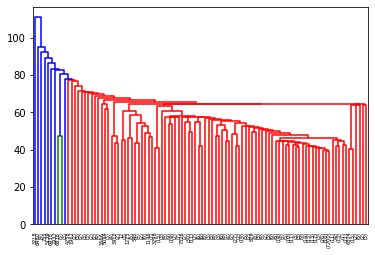

In [94]:
dendo = sc_hierarchy.dendrogram(link, p=100, truncate_mode='lastp')
plt.show()


In [95]:
print("After making the plot more readible by removing its right part that was not of interest for this question,It seems like for k = 100, there is only one cluster here")

After making the plot more readible by removing its right part that was not of interest for this question,It seems like for k = 100, there is only one cluster here


In [73]:
#######4
f= open("\\Users\\pgard\\sta-663-2020\\data\\mystery.txt","r").read()

In [74]:
import string 
# Creating a dictionary of all the words
word_dict = {cont: 
             docs[cont].strip().lower().translate(str.maketrans('', '', string.punctuation)).split() for cont in docs}

# Putting of this words in a combined list
sub_words=[]
for i in word_dict.keys():
    sub_words+=[word_dict[i]]

words = []
for i in sub_words:
    words += i
# extracting only unique words    
words = list(dict.fromkeys(words))

In [82]:
list_f= f.strip().lower().translate(str.maketrans('', '', string.punctuation)).replace('\n', ' ').replace('¿', ' ').split()
new_doc=[]
for i in range(len(list_f)):
    if not list_f[i] in words:
        list_f[i]=None
    else:
        pass
f.close()

**Notes on the Pubmed articles**

These were downloaded with the following script.

```python
from Bio import Entrez, Medline
Entrez.email = "YOUR EMAIL HERE"
import cPickle

try:
    docs = cPickle.load(open('pubmed.pic'))
except Exception, e:
    print e

    docs = {}
    for term in ['plasmodium', 'diabetes', 'asthma', 'cytometry']:
        handle = Entrez.esearch(db="pubmed", term=term, retmax=50)
        result = Entrez.read(handle)
        handle.close()
        idlist = result["IdList"]
        handle2 = Entrez.efetch(db="pubmed", id=idlist, rettype="medline", retmode="text")
        result2 = Medline.parse(handle2)
        for record in result2:
            title = record.get("TI", None)
            abstract = record.get("AB", None)
            if title is None or abstract is None:
                continue
            docs[title] = '\n'.join([title, abstract])
            print title
        handle2.close()
    cPickle.dump(docs, open('pubmed.pic', 'w'))
docs.values()
```